Last Updated 19/7/2023

This notebook is part of a broader investigation into how we can use ratings more effectively in the neural network. This includes: 
- incorporating Moody's ratings in some way 
- incorporating rating downgrades effectively, whether explicit or implicit (such as when a bond is prerefunded)

The following notebook is an investigation into the effectiveness of ratings in the neural network. **Jump to the section *Pricing Hypothetical Trades* for the analysis**.  

Initial analysis showed that the current model (tested using the model in deployment right now) is not as sensitive to exogenous ratings changes as expected (a downgrade from 'AAA' to Junk yielded a change in predictions ranging between 1-40bps). A look into the embeddings from the production model, however, showed that the embeddings did preserve the semantics of different ratings (ratings close together have similar vectors). 

My suspicion from this is that the model is not learning to use ratings appropriately downstream, since vector embeddings appear sensible but predictions do not. Before moving forward with using Moody's ratings, I looked into trying to help the network get more out of ratings.

**Intuition (if there is a more concrete way of testing this please let me know)**: The current network concatenates the multi-dimensional output from the LSTM sub-model and reference data sub-model and feeds that output through a series of dense layers to output a predicted yield spread. Because the outputs of each of the sub-models is multi-dimensional, we can think of them more as encodings of trade_history and reference data. My intuition is that this combination of encodings -> several dense layers downstream creates multiple interactions between the trade history and the reference data inputs and, since using the previous yield is very often the single best predictor of current yield, this muddles the model's ability to learn from reference data.

**TLDR:** The idea implemented here is simple: separate the trade history and reference sub-models more clearly. Each sub-model outputs a single scalar value which is combined in the final layer, which aligns the sub-models more closely with the idea of each of them predicting a yield spread and combining those predictions for a final predicted yield spread. Over 8 runs and in the data used in this notebook, MAE improves on average by ~0.4bps. Moreover, this new model is more sensitive to changes in ratings (and presumably, other reference data features, which I'll test some other time). This is ascertained in the same way that the original model was deemed to be insufficiently sensitive - we alter ratings for real trades and see how predictions change under the altered ratings, all else equal.

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-07-19 17:55:14.991069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 17:55:15.241574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 17:55:15.243347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-05-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.01 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 2
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-05-01 2023-06-01 2023-06-01 2023-07-01


# Load Data and Train NN

In [307]:
# upload_data(storage_client, 'isaac_data', 'processed_file_FULL_2023-07-12-17:22.pkl')

File processed_file_FULL_2023-07-12-17:22.pkl uploaded to isaac_data.


In [12]:
%time processed_data = load_data_from_pickle('processed_file_FULL_2023-07-12-17:22.pkl')

File available, loading pickle
CPU times: user 11.6 s, sys: 4.14 s, total: 15.8 s
Wall time: 27.6 s


In [13]:
processed_data = processed_data[~(processed_data.trade_history.apply(lambda x: x.shape) == (5,6))]

In [14]:
processed_data['trade_history'] = processed_data.trade_history.apply(lambda x: x[:,[0,2,3,4,5,6]])

In [15]:
processed_data['target_attention_features'] = processed_data['target_attention_features'].apply(lambda x: x[[0],:])

In [16]:
processed_data['target_attention_features'].iloc[0].shape

(1, 3)

## Checking data

In [17]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'))

In [18]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,1746702.000,1746702.000
mean,364.498,323.013
std,91.917,41.183
min,0.100,263.663
25%,307.000,297.164
50%,350.300,310.806
75%,411.000,336.136
max,9892.500,541.456


In [19]:
processed_data.reset_index(drop=True, inplace=True)

In [20]:
processed_data['new_ys_realtime'] = processed_data['yield'] - processed_data['new_real_time_ficc_ycl']
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

In [21]:
##### EXTRA DATA PREPROCESSING #####
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

def process_data(data): 
    data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [22]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 34.8 s, sys: 5.51 s, total: 40.3 s
Wall time: 1min 24s


In [23]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 832 ms, sys: 19 ms, total: 851 ms
Wall time: 868 ms


In [24]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 18.1 s, sys: 3.99 s, total: 22.1 s
Wall time: 23.5 s


In [25]:
# for col in NON_CAT_FEATURES:
#     print(col + ':' + str(train_dataframe[col].isna().sum()))

In [26]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [27]:
processed_data = process_data(processed_data)

In [37]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
# for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
#     if col not in PREDICTORS:
#         PREDICTORS.append(col)
#         NON_CAT_FEATURES.append(col)
        
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [38]:
%%time

processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 790 ms, sys: 51.5 ms, total: 842 ms
Wall time: 840 ms


In [39]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

CPU times: user 762 ms, sys: 91.7 ms, total: 853 ms
Wall time: 853 ms


In [40]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'), 1590785)

In [41]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-05-01 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [42]:
print(train_dataframe.trade_date.min(), train_dataframe.trade_date.max(), len(train_dataframe))
print(test_dataframe.trade_date.min(), test_dataframe.trade_date.max(), len(test_dataframe))

2023-05-01 00:00:00 2023-05-31 00:00:00 705233
2023-06-01 00:00:00 2023-06-30 00:00:00 697202


In [67]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    for col in yield_history_cols:
        datalist.append(np.stack(df[col].to_numpy()))
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    # for i in range(num_yield_history):
    #     inputs.append(layers.Input(name=f"yield_history_input_{yield_history_cols[i]}", 
    #                                        shape=(yield_history_lengths[i], 1), 
    #                                        dtype = tf.float32))
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)

    ####################################################
    
#     ############## YIELD HISTORY MODEL #################
#     yield_history_outputs = []
#     for i in range(num_yield_history):
#         yield_lstm_layer = layers.Bidirectional(layers.LSTM(50, 
#                                  activation='tanh',
#                                  input_shape=(yield_history_lengths[i], 1),
#                                  return_sequences = False,
#                                  name=f'Yield_History_LSTM_{yield_history_cols[i]}'))

#         yield_features = yield_lstm_layer(yield_history_normalizers[i](inputs[i]))
#         yield_history_outputs.append(layers.Dense(25, activation='relu')(yield_features))
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate(yield_history_outputs+[reference_output, trade_history_output])

    # hidden = layers.Dense(10,activation='relu')(feed_forward_input)
    # hidden = layers.BatchNormalization()(hidden)
    # hidden = layers.Dropout(DROPOUT)(hidden)

#     hidden2 = layers.Dense(100,activation='relu')(hidden)
#     hidden2 = layers.BatchNormalization()(hidden2)
#     hidden2 = layers.Dropout(DROPOUT)(hidden2)
    # final = layers.Dense(1)(hidden2)
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)

    # Normalization layer for the trade history
    trade_history_normalizer = Normalization(name='Trade_history_normalizer')
    trade_history_normalizer.adapt(x_train[num_yield_history],batch_size=BATCH_SIZE)

    # Normalization layer for the non-categorical and binary features
    noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
    noncat_binary_normalizer.adapt(x_train[num_yield_history+2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

In [44]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [45]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model



In [46]:
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

In [47]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [49]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe[test_dataframe.trade_date<='2023-06-09'], trade_history_col, yield_history_cols)

TRAINING DATA: N = 634710, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 70523, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 235624, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-09 00:00:00


2023-07-19 18:05:58.788269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 18:05:58.792029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 18:05:58.795655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 18:05:58.798224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [50]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

14
(634710, 2, 6)
(634710, 1, 3)
(634710, 48)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)


In [ ]:
results = []
predictions = []
NUM_EPOCHS = 75

for i in range(1):
    tf.keras.utils.set_random_seed(10)
    start = time.time()
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

In [63]:
results = []
predictions = []
NUM_EPOCHS = 75

for i in range(1):
    tf.keras.utils.set_random_seed(10)
    start = time.time()
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

========================= TRIAL 0, MAE: 9.408028809369103, TIME TAKEN: 23.9 =========================


In [51]:
#SECOND RUN ON 07/15; 75 EPOCHS
#NOTE: initial run erroneously included  the 
t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 9.398
Trial 2: 9.444
Trial 3: 9.424
Trial 4: 9.441
Trial 5: 9.454
Trial 6: 9.441
Trial 7: 9.409
Trial 8: 9.456
Average MAE: 9.433


# Pricing Hypothetical Trades

In [7]:
# synthetic_sampled_data = pd.read_pickle('synthetic_sampled_data_new.pkl')
# baseline_data = pd.read_pickle('synthetic_sampled_data_baseline.pkl')

In [64]:
def get_days(row, col):
    if pd.isna(row[col]) or pd.isna(row['settlement_date']):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.settlement_date)
        if diff <= 0:
            return -1
        else:
            return diff
        
def sample_dataframe(df, N):
    '''Takes a dataframe from pd.groupby and samples N rows from it without replacement. The group name (in this case, the groupby index) is saved
    to a dictionary, groupby_id_dict'''
    
    group_name = df.name
    def index_to_dict(index_row):
        is_callable = index_row[0]
        interval = str(index_row[1].left)+'-'+str(index_row[1].right)
        rating = index_row[2]
        return {'is_callable':is_callable, 'interval': interval, 'rating':rating}
    
    df = df.drop_duplicates(subset='cusip')
    
    if len(df) < N:
        N = len(df)
    
    np.random.seed(1)
    result = df.sample(N, replace=False) 
    group_id = next(COUNT)
    result['group'] = group_id
    groupby_id_dict[group_id] = index_to_dict(group_name)
    return result


def create_synthetic_samples(df, col, vals):
    '''For a given cusip, the first trade is sampled and hypothetical trades are appended with by varying the column defined in col with values in vals'''
    for cusip in df.cusip.unique():
        for val in vals:
            temp = df[df.cusip == cusip].iloc[0] 
            if val != temp[col]:
                temp[col] = val
                df = df.append(temp)
    return df

def make_summary(col):
    '''Calculates the Max-Min range by cusip'''
    summary_df = synthetic_sampled_data.groupby(['cusip'])\
    ['predictions']\
    .agg(['std', max_min_f])\
    .rename({'<lambda_0>':'Max-Min'}, axis=1)\
    
    summary_df = summary_df.join(synthetic_sampled_data.set_index('cusip')[col])
    
    summary_df = summary_df.groupby(col).mean()
    # summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)
    
    display(summary_df)
    
    return summary_df

In [65]:
data = test_dataframe[test_dataframe.trade_date <= '2023-06-09'].copy()
# data['days_to_call'] = data[['settlement_date','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity'] = data[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity_bucket'] = pd.cut(data['maturity'], [0, 5, 10, 15, 20, 30, data.maturity.max()])

In [79]:
#We just look at 5 rating values for efficiency 
RATINGS = ['AAA',  'BBB', 'CCC', 'NR']
groupby_cols = ['is_callable','maturity_bucket','rating']

sampled_data = data[data.rating.isin(RATINGS)].groupby(groupby_cols)
COUNT = iter(range(len(sampled_data.groups)))
groupby_id_dict = dict()

#Sample 20 random cusips from each maturity bucket, rating and callable combination 
sampled_data = sampled_data.apply(lambda x: sample_dataframe(x, 20)).reset_index(drop=True)

%time synthetic_sampled_data = create_synthetic_samples(sampled_data, 'rating', RATINGS)

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 9s


In [83]:
#Create input for model using original sampled data and sampled data augmented with hypothetical trades 
X_sample = create_input_new(sampled_data, trade_history_col, [])
X_sample_hypothetical_trades = create_input_new(synthetic_sampled_data, trade_history_col, [])

sampled_data_predictions  = model.predict(X_sample).flatten()
sampled_data_hypothetical_predictions  = model.predict(X_sample_hypothetical_trades).flatten()

sampled_data['predictions'] = sampled_data_predictions
synthetic_sampled_data['predictions'] = sampled_data_hypothetical_predictions

In [84]:
#to calculate max-min range within cusip
max_min_f = lambda x: x.max() - x.min()

synthetic_sampled_data['original_rating'] = synthetic_sampled_data['group'].apply(lambda x: groupby_id_dict[x]['rating'])

make_summary('is_callable');
make_summary('original_rating');
make_summary('maturity_bucket');

,std,Max-Min
is_callable,,
False,7.091,15.712
True,7.097,15.874


,std,Max-Min
original_rating,,
AAA,6.421,14.320
BBB,8.491,18.684
CCC,14.252,32.472
NR,6.532,14.751


,std,Max-Min
maturity_bucket,,
"(0.0, 5.0]",10.316,23.087
"(5.0, 10.0]",7.594,16.809
"(10.0, 15.0]",6.681,14.900
"(15.0, 20.0]",6.455,14.379
"(20.0, 30.0]",5.786,12.823
"(30.0, 46.136]",2.408,5.353


In [5]:
# synthetic_sampled_data.to_pickle('synthetic_sampled_data_new.pkl')

In [74]:
baseline_data = pd.read_pickle('synthetic_sampled_data_baseline.pkl')

In [95]:
A = synthetic_sampled_data.copy().drop_duplicates(subset=['cusip','rating'])
B = baseline_data.copy().drop_duplicates(subset=['cusip','rating'])
# print(len(A), len(B))

A['join'] = A['cusip']+'_'+A['rating']
B['join'] = B['cusip']+'_'+B['rating']

comp = pd.merge(A, 
             B[[ 'predictions', 'join']].rename({'predictions':'baseline_model_predictions'}, axis=1),
             left_on='join',
             right_on='join').drop('join',axis=1)

comp['predictions'] = comp['predictions'] + comp['new_ficc_ycl']
comp['baseline_model_predictions'] = comp['baseline_model_predictions'] + comp['new_ficc_ycl']

comp['baseline_error'] = comp['yield'] - comp['baseline_model_predictions']
comp['error'] = comp['yield'] - comp['predictions']

In [104]:
comp[['baseline_error','error']].corr().iloc[0,1]

0.8349471065120854

In [124]:
#Visualize some of the predictions with smallest and largest errors 
temp_df = comp[comp.rating == comp.original_rating]
select_cols = ['cusip', 'original_rating', 'rating', 'yield', 'predictions','baseline_model_predictions','error', 'baseline_error']
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).head())
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).tail())
display(temp_df[select_cols].sort_values(by='error', key = abs).head())
display(temp_df[select_cols].sort_values(by='error', key = abs).tail())

,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
139,13033DAL9,BBB,BBB,443.700,445.462,443.663,-1.762,0.037
8,414005S82,AAA,AAA,331.000,336.567,331.039,-5.567,-0.039
346,9771234C9,AAA,AAA,325.800,323.041,325.911,2.759,-0.111
61,5917455N0,AAA,AAA,283.000,276.238,283.166,6.762,-0.166
481,346843VR3,AAA,AAA,377.700,379.924,377.495,-2.224,0.205


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
275,41422MHD0,BBB,BBB,487.500,425.365,408.090,62.135,79.410
285,592240UN3,NR,NR,426.000,501.400,518.592,-75.400,-92.592
381,881830K28,NR,NR,513.900,420.316,417.852,93.584,96.048
59,919526AG8,NR,NR,503.300,392.138,398.941,111.162,104.359
459,13080STQ7,BBB,BBB,673.000,554.534,529.582,118.466,143.418


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
268,696344LC2,AAA,AAA,307.000,306.975,307.656,0.025,-0.656
493,646080XL0,BBB,BBB,500.800,500.827,501.599,-0.027,-0.799
385,914713S60,AAA,AAA,341.300,341.271,351.052,0.029,-9.752
260,542264GP5,AAA,AAA,331.500,331.439,325.646,0.061,5.854
129,134159YL0,AAA,AAA,280.000,280.112,281.319,-0.112,-1.319


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
285,592240UN3,NR,NR,426.000,501.400,518.592,-75.400,-92.592
54,64986AJB8,NR,NR,322.200,400.288,379.557,-78.088,-57.357
381,881830K28,NR,NR,513.900,420.316,417.852,93.584,96.048
59,919526AG8,NR,NR,503.300,392.138,398.941,111.162,104.359
459,13080STQ7,BBB,BBB,673.000,554.534,529.582,118.466,143.418


Here we look at the average and standard deviation of the within-CUSIP Max-Min Range between the new model and the original model. The mean range and standard deviation of the ranges are larger for the new model's predictions, suggesting that it is more sensitive to ratings changes. Based on the histogram below, we see the same trend, though subtle - predicted yields stretch further out for the new model.

Average Max-Min Range across all CUSIPS:
 predictions                  15.792
baseline_model_predictions   11.027
dtype: float64

Std of Max-Min Range across all CUSIPS:
 predictions                  12.728
baseline_model_predictions    9.027
dtype: float64


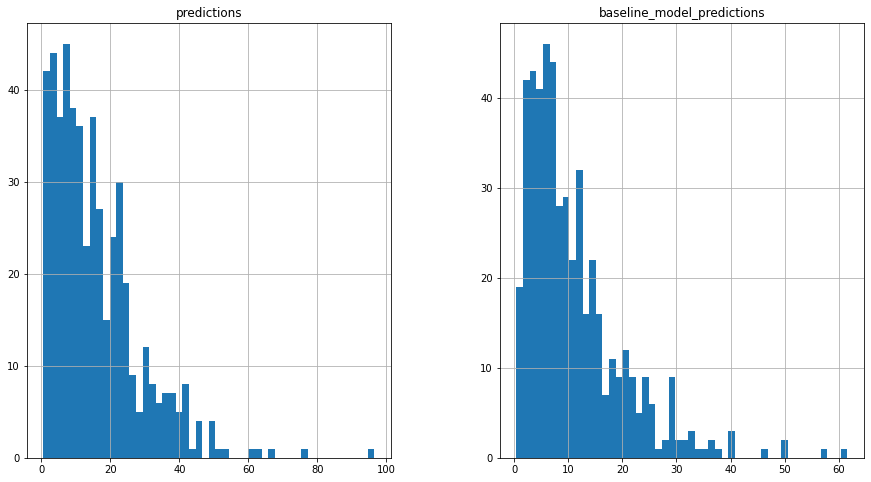

In [148]:
temp = comp.groupby('cusip')[['predictions','baseline_model_predictions']].apply(max_min_f)
print('Average Max-Min Range across all CUSIPS:\n', temp.mean())
print()
print('Std of Max-Min Range across all CUSIPS:\n', temp.std())
temp.hist(figsize=(15, 8), bins = 50);

Where the new_model has a larger range, that range averages 9.1bps. Where the baseline model has a larger range, that range averages 4.7bps. It is also twice as common for the new model to have a larger range (342 v 158)

In [91]:
len(temp[temp.predictions>temp.baseline_model_predictions]), len(temp[temp.predictions<temp.baseline_model_predictions])

(342, 158)

In [92]:
temp[temp.predictions>temp.baseline_model_predictions].diff(axis=1).mean()

predictions                     NaN
baseline_model_predictions   -9.156
dtype: float64

In [93]:
temp[temp.predictions<temp.baseline_model_predictions].diff(axis=1).mean()

predictions                    NaN
baseline_model_predictions   4.740
dtype: float64

Here we look at the average Max-Min range based on original rating and maturity. Predictions are more sensitive for bonds with lower ratings and shorter maturities. Obviously the impact of features like ratings on predictions is non-linear in the network, but this trend likely tells us also that bonds with lower ratings systematically have other features in favor of higher yields. In any case, the predictions of the new model are more sensitive.

In [139]:
comp.groupby(['cusip','original_rating'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('original_rating')\
.mean()

,predictions,baseline_model_predictions
original_rating,,
AAA,14.320,9.505
BBB,18.684,12.805
CCC,32.472,21.623
NR,14.751,11.453


In [326]:
comp.groupby(['cusip','maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('maturity_bucket')\
.mean()

,predictions,baseline_model_predictions
maturity_bucket,,
"(0.0, 5.0]",23.087,17.145
"(5.0, 10.0]",16.809,12.383
"(10.0, 15.0]",14.900,9.303
"(15.0, 20.0]",14.379,9.152
"(20.0, 30.0]",12.823,8.708
"(30.0, 46.136]",5.353,4.827


In [323]:
temp = comp.groupby(['cusip','original_rating', 'maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()

In [324]:
temp[temp.baseline_model_predictions>temp.predictions].sort_values('baseline_model_predictions', ascending=False).head(20)

,cusip,original_rating,maturity_bucket,predictions,baseline_model_predictions
211,491501DX7,NR,"(0.0, 5.0]",36.510,61.609
157,41420LRE1,BBB,"(0.0, 5.0]",49.885,57.531
25,080401RB0,AAA,"(20.0, 30.0]",22.446,49.999
246,57584XAF8,BBB,"(0.0, 5.0]",44.560,46.915
99,235839CZ8,BBB,"(0.0, 5.0]",37.524,40.577
204,486189GS6,BBB,"(0.0, 5.0]",29.103,40.356
122,34282CLH2,NR,"(10.0, 15.0]",35.861,38.203
76,19648A6C4,NR,"(5.0, 10.0]",12.524,35.102
135,3733846D3,AAA,"(0.0, 5.0]",10.847,33.524
154,413890DK7,BBB,"(30.0, 46.136]",12.189,32.947


We also check the model for consistency - in general, there is little reason for yields to go down if a bond's rating is downgraded. In other words, the relationship between rating and yield should be monotonically increasing. The model is more consistent if this happens. The code below checks for the consistency of yields in hypothetical trades if the yields are increasing from AAA -> BBB -> CCC (we drop NR hypothetical trades). We also check for the more general case where yields are higher when rating is AAA compared to CCC. 

Again, we see that the new model is more consistent. In particular, it is twice more likely to have monotonically increasing yields as rating decreases.

In [211]:
def check_monotonic(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']].diff()
    return ~(df <= 0).any(axis=0)

def check_monotonic_start_end(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']]
    df = df.iloc[-1] - df.iloc[0]
    return df >= 0

is_monotonic = comp.groupby('cusip').apply(check_monotonic)
is_monotonic_start_end = comp.groupby('cusip').apply(check_monotonic_start_end)

display(is_monotic.mean())
display(is_monotonic_start_end.mean())

predictions                  0.550
baseline_model_predictions   0.238
dtype: float64

predictions                  0.884
baseline_model_predictions   0.830
dtype: float64

Look at embeddings: 
(in progress)

In [292]:
baseline_model = keras.models.load_model('baseline_model/')

In [296]:
from sklearn.metrics.pairwise import cosine_similarity

In [304]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
rating_embedding_layer = baseline_model.get_layer('rating_embed')
rating_embedding_weights = rating_embedding_layer.get_weights()[0]

dist_all = []
for i, arr1 in enumerate(rating_embedding_weights):
    dist = []
    for j, arr2 in enumerate(rating_embedding_weights):
        dist.append(cosine_similarity(arr1.reshape(1,-1),
                                      arr2.reshape(1,-1))[0][0])
    dist_all.append(dist)

# encoded_ratings = pd.DataFrame({x:[y] for x, y in zip(categorical_feature_values['rating'], rating_embedding_weights)}).T

encoded_ratings = pd.DataFrame(dist_all, 
             index = categorical_feature_values['rating'],
            columns = categorical_feature_values['rating'])

for col in encoded_ratings.columns:
    print(f'{col}: {sorted(encoded_ratings[col].drop(col).sort_values(ascending=True).head(3).index.values)}')

A: ['AA+', 'AAA', 'CCC']
A+: ['AAA', 'B-', 'CCC+']
A-: ['AA+', 'AAA', 'CCC-']
AA: ['BB+', 'BB-', 'D']
AA+: ['B', 'BB-', 'CC']
AA-: ['B-', 'CCC', 'CCC+']
AAA: ['A-', 'BB+', 'BBB']
B: ['AA', 'AA+', 'B+']
B+: ['BB+', 'CCC+', 'MR']
B-: ['AA+', 'AA-', 'B+']
BB: ['A', 'A+', 'AA+']
BB+: ['AAA', 'B+', 'CC']
BB-: ['AA', 'AA+', 'B+']
BBB: ['AA+', 'AAA', 'D']
BBB+: ['AA+', 'AA-', 'AAA']
BBB-: ['AA-', 'AAA', 'CC']
CC: ['AA+', 'BB+', 'CCC+']
CCC: ['AA-', 'B+', 'CC']
CCC+: ['AA-', 'B+', 'CC']
CCC-: ['A-', 'AA', 'CC']
D: ['AA', 'BBB', 'MR']
NR: ['A+', 'A-', 'B+']
MR: ['AA+', 'AA-', 'B+']
